In [1]:
%%time

import numpy as np
from numpy import percentile
import pandas as pd
import os
import copy
import time

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
np.random.seed(22)

import tensorflow as tf
#tf.debugging.set_log_device_placement(True)


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import pydot
#import tensorflow_docs as tfdocs

print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


2021-11-24 12:42:34.529373: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9089086843564307121
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23377477632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3484098118099128515
physical_device_desc: "device: 0, name: GeForce RTX 3090, pci bus id: 0000:03:00.0, compute capability: 8.6"
]


2021-11-24 12:42:35.729754: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-24 12:42:35.733345: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-24 12:42:35.802744: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-11-24 12:42:35.802783: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-11-24 12:42:35.806331: I tensorflow/stream_executor/platform/default/dso_loader.cc:

CPU times: user 6.18 s, sys: 5.57 s, total: 11.7 s
Wall time: 3.17 s


In [2]:
print('working directory: ',os.getcwd())
Files = [file for file in sorted(os.listdir('/home/share/TMD_Colab/validation/data/training')) 
         if file.endswith('.pkl') and file.split("_")[2]=="test"]
print('\ntest data files found: \n',Files)
# file = Files[0]
# file = 'EIC_test_data_tmdaff.pkl'



working directory:  /home/share/TMD_Colab/validation/testing

test data files found: 
 ['EIC_aff_test_collinearaff.pkl', 'EIC_aff_test_currentaff.pkl', 'EIC_aff_test_targetaff.pkl', 'EIC_aff_test_tmdaff.pkl']


In [3]:
# Define plotting function


def plotPred(trueVal,predVal,title,threshold):
    fig=plt.figure(figsize=(10,10))
    a = plt.axes(aspect='equal')
    plt.scatter(trueVal, predVal,alpha=0.05)
    plt.xlabel('True Values [Affinity]',fontsize=20)
    plt.ylabel('Predictions [Affinity]',fontsize=20)
    plt.title(title,fontsize=25)
    lims = [0, 1]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims ,color = 'k',linestyle='-')
    # add lines for residual threshold and center
    x1 = np.linspace(0,1-threshold,100)
    plt.plot(x1,x1+threshold, color = 'r',linestyle='--')
    x2 = np.linspace(threshold,1,100)
    plt.plot(x2,x2-threshold, color = 'r',linestyle='--')
    plt.show()
#     from matplotlib.backends.backend_pdf import PdfPages
#     with PdfPages('../figures/tmd_sigmoid.pdf') as pdf:
#         pdf.savefig(fig)
#    plt.savefig('../figures/tmd_sigmoid.png')


def getThresh(residuals):
    badRes = np.ones(len(residuals)).tolist()
    lowThresh = 0.0000000001
    upperThresh = 1.
    threshold = lowThresh
    tolerance = 0.000001
    atol = len(badRes)/len(residuals)
    iterCount = 0

    while np.abs(atol - .05) > tolerance :

        badRes = [res for res in residuals if np.abs(res) > threshold]
        atol = len(badRes)/len(residuals)

        if np.abs(atol - 0.05) < tolerance: 
            break

        else:
            if atol < 0.05:
                upperThresh = threshold
            else:
                lowThresh = threshold
                
        threshold = (upperThresh + lowThresh)/2 
        iterCount += 1

    print('# residuals: ',len(residuals))
    print('# residuals outside threshold: ',len(badRes))
    print('percent residuals outside threshold: ',len(badRes)/len(residuals))
    print('max badRes: ', max(np.abs(badRes)),', max residual: ',max(np.abs(residuals)))
    print('min BadRes: ', min(np.abs(badRes)))
    print('threshold: ', threshold)
    print('# of iterations: ',iterCount)
    print('#'*12,'\n'*2)
    print('Percent residuals within +/- %s' % threshold)
    accuracy = len([res for res in residuals if np.abs(res) <= threshold])/len(residuals)
    print('accuracy: ',accuracy)
    print('Percent residuals == 0.0')
    accuracy = len([res for res in residuals if np.abs(res) == 0.0])/len(residuals)
    print('accuracy: ',accuracy)
    return(threshold)


def getThresh2(residuals):
    threshold = percentile(residuals, [2.5, 97.5])
    print('Percent residuals within %s' % threshold)
    accuracy = np.mean((residuals > threshold[0]) & (residuals < threshold[1]))
    print('accuracy: ',accuracy)
    print('Percent residuals == 0.0')
    accuracy = np.mean(residuals == 0.0)
    print('accuracy: ',accuracy)
    return(threshold)


def fivenumsum(resids):
    
    # calculate a 5-number summary
    from numpy import percentile
    quartiles = percentile(resids, [0, 25, 50, 75, 100])
    # print 5-number summary
    print('Min: %.3f' % quartiles[0])
    print('Q1: %.3f' % quartiles[1])
    print('Median: %.3f' % quartiles[2])
    print('Q3: %.3f' % quartiles[3])
    print('Max: %.3f' % quartiles[4])
    


In [4]:
# # test tmd model and create plots for visualization of results
# model_name = 'tmd_DNN_V2_sigmoid_checkpoint_model'

# model_name=name+'_cp_model'

def scot_plot(mld_path, file_path, lable_name, ):
    
    test_results = {}
    model = tf.keras.models.load_model(mld_path)
    test_features = np.load(file_path,allow_pickle=True)
    #test_features = test_features.drop(columns=['currentaff','targetaff', 'collinearaff','hadron'])
    #print(test_features.head())
    test_labels = test_features.pop(lable_name)
    print('Model Configureation')
    print('#'*12,'\n'*2)
    for i, layer in enumerate (model.layers):
        print ('layer', i, layer)
        try:
            print ("    ",layer.activation)
        except AttributeError:
            print('   no activation attribute')
        
    print('#'*12,'\n'*2)
    print('Model Summary')
    print(model.summary())
    test_results[model_name] = model.evaluate(test_features, test_labels, verbose=0)
    test_predictions = model.predict(test_features).flatten()
    print('#'*12,'\n'*2)
#     negPred=[value for value in test_predictions if value < 0]
#     giantPred=[value for value in test_predictions if value > 1]
#     print('# of predictions < 0:',len(negPred),'\n# of predictions > 1:',len(giantPred))

#     if len(negPred)==0 and len(giantPred)==0:
#         print('no correction needed')
#     else:
#         print('setting negative predictions to 0\nsetting predictions > 1 to 1')
#         test_predictions[test_predictions<0] = 0
#         test_predictions[test_predictions>1] = 1
#         print('testing affinity correction...')
#         negPred=[value for value in test_predictions if value < 0]
#         giantPred=[value for value in test_predictions if value > 1]
#         print('# of predictions < 0:',len(negPred),'\n# of predictions > 1:',len(giantPred))

    print('#'*12,'\n'*2)
    residuals = test_labels-test_predictions
    threshold = getThresh(residuals)
    _ = getThresh2(residuals)
    print('#'*12,'\n'*2)
    # badRes = [res for res in list(residuals) if np.abs(res) >= threshold] # residuals that are above threshold
    # #print(badRes)
    # percentBadRes = len(badRes)/len(residuals)

    # Calculate R squared
    print('----------------------------')
    print('\nModel Stats')
    R2 = r2_score(test_labels, test_predictions, multioutput='variance_weighted')
    print('mse: ',test_results[model_name])
    print('R-squared: ',R2)
    # print(np.round(percentBadRes,6),'percent of residuals were above threshold 0.2 for',len(test_labels),' predictions')
    # print(len(badRes),' residuals were above threshold 0.2 for',len(test_labels),' predictions')
    # print('max |residual|: ',max(np.abs(residuals)))
    print('#'*12,'\n'*2)
    print('Five number summary of residuals')
    fivenumsum(residuals)
    print('#'*12,'\n'*2)
    plotPred(test_labels,test_predictions,model_name+' sigmod model',threshold)
    plt.figure(figsize=(10,10))
    plt.hist(residuals,bins=100)
    plt.show()



# TMD 

2021-11-24 12:42:37.453669: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-11-24 12:42:37.455904: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2021-11-24 12:42:37.457264: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-11-24 12:42:37.459478: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2021-11-24 12:42:37.459517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-11-24 12:42:37.459525: I tensorflow/core/common_ru

Model Configureation
############ 


layer 0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9e9685d310>
   no activation attribute
layer 1 <tensorflow.python.keras.layers.preprocessing.normalization.Normalization object at 0x7f9e9685d940>
   no activation attribute
layer 2 <tensorflow.python.keras.layers.core.Dense object at 0x7f9e7c7cc310>
     <function relu at 0x7fa099ead310>
layer 3 <tensorflow.python.keras.layers.core.Dense object at 0x7f9e7c7cc8e0>
     <function relu at 0x7fa099ead310>
layer 4 <tensorflow.python.keras.layers.core.Dense object at 0x7f9e7c7ccee0>
     <function sigmoid at 0x7fa099ead670>
############ 


Model Summary
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
normalization (Normalization (None, 7)              

2021-11-24 12:42:38.289354: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-24 12:42:38.311018: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2294645000 Hz
2021-11-24 12:42:38.445701: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-11-24 12:42:39.231541: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-11-24 12:42:39.231612: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


############ 


############ 


# residuals:  740000
# residuals outside threshold:  37000
percent residuals outside threshold:  0.05
max badRes:  0.33819463462821187 , max residual:  0.33819463462821187
min BadRes:  0.013039202785573356
threshold:  0.013039112189760543
# of iterations:  21
############ 


Percent residuals within +/- 0.013039112189760543
accuracy:  0.95
Percent residuals == 0.0
accuracy:  0.11832702702702702
----------------------------

Model Stats
mse:  3.2717842259444296e-05
R-squared:  0.9998366469894787
############ 


Five number summary of residuals
Min: -0.141
Q1: -0.000
Median: -0.000
Q3: 0.000
Max: 0.338
############ 




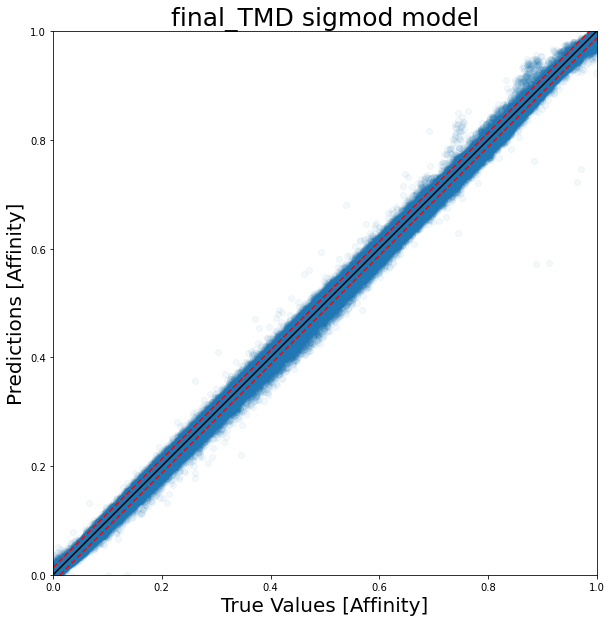

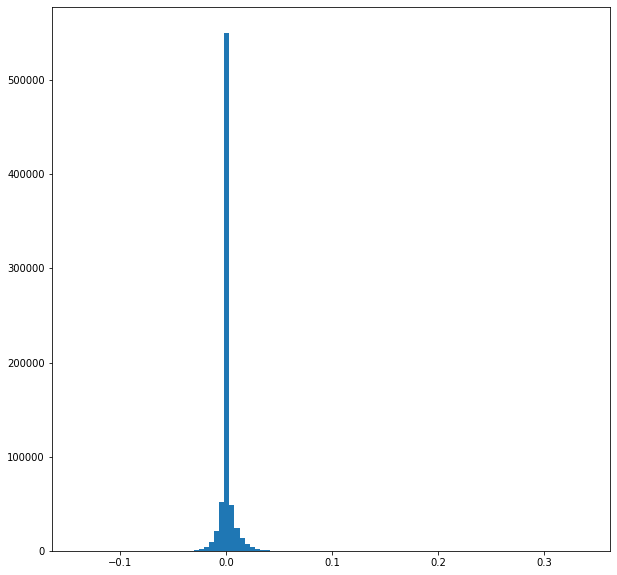

CPU times: user 1min 55s, sys: 13.1 s, total: 2min 8s
Wall time: 1min 18s


In [5]:
%%time

# region_name = 'collinear'
# region_name = 'current'
# region_name = 'target'
region_name = 'TMD'
# lable_name = 'collinearaff'
# lable_name = 'targetaff'
# lable_name = 'currentaff'
lable_name = 'tmdaff'
file_name = 'EIC_aff_test_%s.pkl' % lable_name
file_path = '/home/share/TMD_Colab/validation/data/training/' + file_name
model_name = 'final_' + region_name
mld_path = '/home/share/TMD_Colab/validation/training/models/' + model_name

scot_plot(mld_path, file_path, lable_name)

# Current

Model Configureation
############ 


layer 0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9e968b3760>
   no activation attribute
layer 1 <tensorflow.python.keras.layers.preprocessing.normalization.Normalization object at 0x7f9e7c2dd8e0>
   no activation attribute
layer 2 <tensorflow.python.keras.layers.core.Dense object at 0x7f9e7c2ee5b0>
     <function relu at 0x7fa099ead310>
layer 3 <tensorflow.python.keras.layers.core.Dense object at 0x7f9e7c280760>
     <function relu at 0x7fa099ead310>
layer 4 <tensorflow.python.keras.layers.core.Dense object at 0x7f9e7c280d60>
     <function sigmoid at 0x7fa099ead670>
############ 


Model Summary
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
normalization (Normalization (None, 7)              

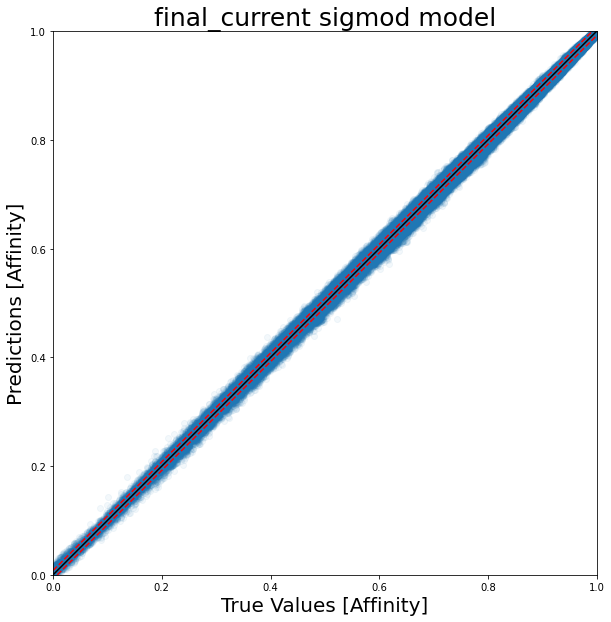

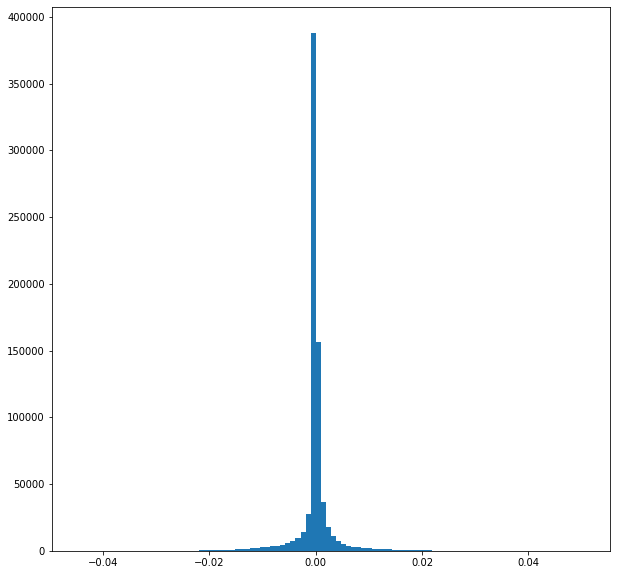

CPU times: user 1min 57s, sys: 11.9 s, total: 2min 9s
Wall time: 1min 20s


In [6]:
%%time

# region_name = 'collinear'
# region_name = 'target'
region_name = 'current'
# region_name = 'TMD'
lable_name = region_name + 'aff'
file_name = 'EIC_aff_test_%s.pkl' % lable_name
file_path = '/home/share/TMD_Colab/validation/data/training/' + file_name
model_name = 'final_' + region_name
mld_path = '/home/share/TMD_Colab/validation/training/models/' + model_name

scot_plot(mld_path, file_path, lable_name)

# Collinear

Model Configureation
############ 


layer 0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9e5c76b8e0>
   no activation attribute
layer 1 <tensorflow.python.keras.layers.preprocessing.normalization.Normalization object at 0x7f9e7c188880>
   no activation attribute
layer 2 <tensorflow.python.keras.layers.core.Dense object at 0x7f9e5c6ce5b0>
     <function relu at 0x7fa099ead310>
layer 3 <tensorflow.python.keras.layers.core.Dense object at 0x7f9e5c6cebb0>
     <function relu at 0x7fa099ead310>
layer 4 <tensorflow.python.keras.layers.core.Dense object at 0x7f9e5c6e8040>
     <function sigmoid at 0x7fa099ead670>
############ 


Model Summary
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
normalization (Normalization (None, 7)              

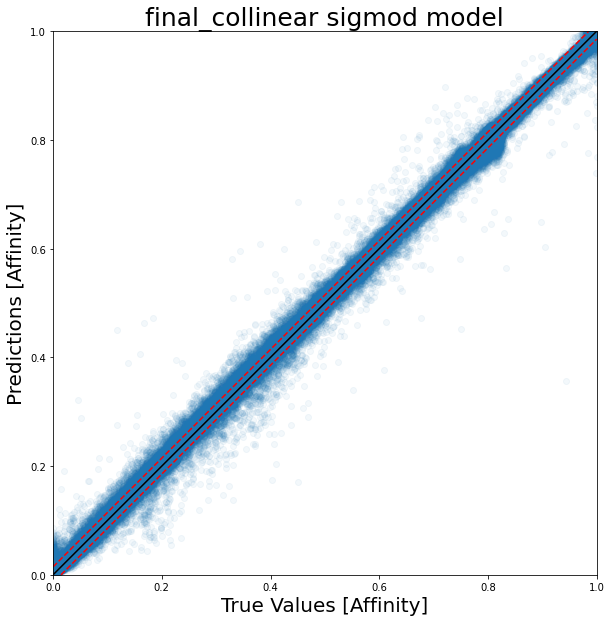

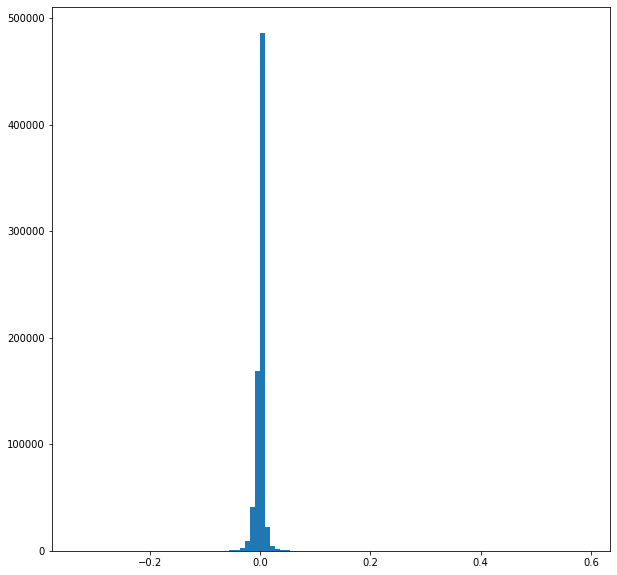

CPU times: user 1min 58s, sys: 11.4 s, total: 2min 9s
Wall time: 1min 22s


In [7]:
%%time

region_name = 'collinear'
# region_name = 'target'
# region_name = 'current'
# region_name = 'TMD'
lable_name = region_name + 'aff'
file_name = 'EIC_aff_test_%s.pkl' % lable_name
file_path = '/home/share/TMD_Colab/validation/data/training/' + file_name
model_name = 'final_' + region_name
mld_path = '/home/share/TMD_Colab/validation/training/models/' + model_name

scot_plot(mld_path, file_path, lable_name)

# target

Model Configureation
############ 


layer 0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9e7c2d14c0>
   no activation attribute
layer 1 <tensorflow.python.keras.layers.preprocessing.normalization.Normalization object at 0x7f9e7c648cd0>
   no activation attribute
layer 2 <tensorflow.python.keras.layers.core.Dense object at 0x7f9e968b3f10>
     <function relu at 0x7fa099ead310>
layer 3 <tensorflow.python.keras.layers.core.Dense object at 0x7f9e968b3b20>
     <function relu at 0x7fa099ead310>
layer 4 <tensorflow.python.keras.layers.core.Dense object at 0x7f9e7c651a00>
     <function sigmoid at 0x7fa099ead670>
############ 


Model Summary
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
normalization (Normalization (None, 7)              

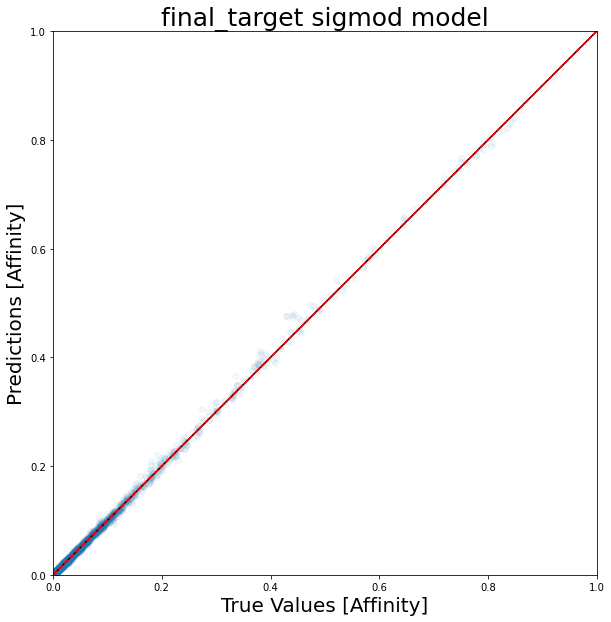

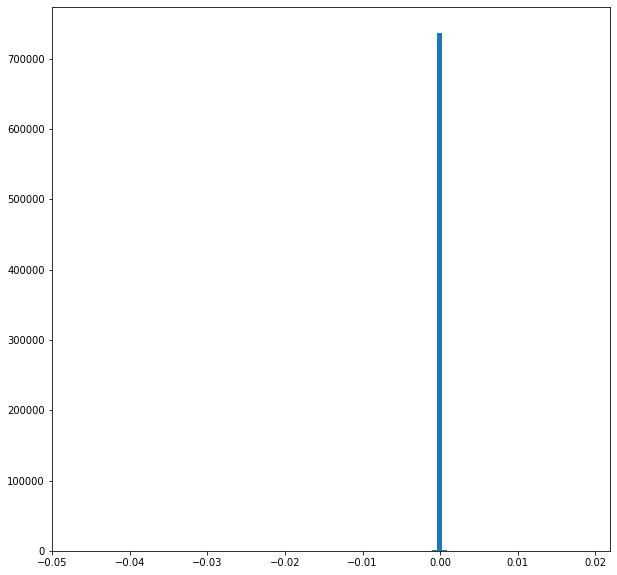

CPU times: user 2min 12s, sys: 11.1 s, total: 2min 23s
Wall time: 1min 36s


In [8]:
%%time

# region_name = 'collinear'
region_name = 'target'
# region_name = 'current'
# region_name = 'TMD'
lable_name = region_name + 'aff'
file_name = 'EIC_aff_test_%s.pkl' % lable_name
file_path = '/home/share/TMD_Colab/validation/data/training/' + file_name
model_name = 'final_' + region_name
mld_path = '/home/share/TMD_Colab/validation/training/models/' + model_name

scot_plot(mld_path, file_path, lable_name)